### **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# from sklearn.utils import shuffle

In [ ]:
train_path = '/content/drive/MyDrive/Datasets/SST-2/train.tsv' # training set
dev_path = '/content/drive/MyDrive/Datasets/SST-2/dev.tsv' # dev set

In [ ]:
# reading file
train_df = pd.read_csv(train_path, sep='\t')
dev_df = pd.read_csv(dev_path, sep='\t')
# data = shuffle(pd.read_csv(filepath, encoding='latin1'))
# data = data.reset_index(drop=True)

In [ ]:
train_df.shape, dev_df.shape

((67349, 2), (872, 2))

In [ ]:
train_df.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [ ]:
dev_df.head()

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


In [ ]:
dev_df['label'].value_counts()

1    444
0    428
Name: label, dtype: int64

In [ ]:
train_df['label'].value_counts()

1    37569
0    29780
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelBinarizer
labelBinary = LabelBinarizer()
 
labels = labelBinary.fit_transform(train_df['label'])
text = train_df['sentence']
# import numpy as np
# val = [
#        [0, 0, 1],
#        [1, 0, 0]
# ]
 
# lb.inverse_transform(np.asarray(val))

In [ ]:
labelBinary.classes_

array([0, 1])

In [ ]:
labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
import pickle

labelpath = '/content/drive/MyDrive/SST-2/label.pkl'
with open(labelpath, 'wb') as handle:
    pickle.dump(labelBinary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(labels.shape, text.shape)

(67349, 1) (67349,)


### **Download & Load Word Vectors for Embedding (Glove)**

* *Download and extract word vectors Glove*

In [ ]:
%%time

import zipfile
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
zip_file = zipfile.ZipFile('glove.840B.300d.zip')
zip_file.extractall()

* *Load Word vectors in memory*

In [ ]:
%%time

from tqdm.notebook import tqdm
import numpy as np 
 
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None

embedding_path = '/content/drive/MyDrive/glove.840B.300d.txt'
embeddings_index = dict(get_coefs(*o.strip().split()) for o in tqdm(open(
    embedding_path)))
 
embed_size=300
 
for k in tqdm(list(embeddings_index.keys())):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
 
if None in embeddings_index:
  embeddings_index.pop(None)
  
values = list(embeddings_index.values())
all_embs = np.stack(values)
 
emb_mean, emb_std = all_embs.mean(), all_embs.std()

0it [00:00, ?it/s]

  0%|          | 0/2195885 [00:00<?, ?it/s]

CPU times: user 3min 13s, sys: 15.6 s, total: 3min 28s
Wall time: 3min 38s


### **Tokenizing the Dataset using keras**



* *Read the train and test file from directory and split the train dataset in train test split*

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
 
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
 
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from tensorflow.keras.layers import Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import TimeDistributed
 
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### **Save Keras Tokenizer**

In [ ]:
text.map(len).max()

268

In [ ]:
%%time
MAX_NB_WORDS = 10000
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)

CPU times: user 1.05 s, sys: 8.73 ms, total: 1.06 s
Wall time: 1.06 s


In [ ]:
%%time
train_sequences = tokenizer.texts_to_sequences(text)

CPU times: user 1.01 s, sys: 14.6 ms, total: 1.02 s
Wall time: 1.02 s


In [ ]:
train_sequences[:3]

[[4568, 87, 31, 1, 7156, 8691],
 [3000, 52, 327, 83, 2055, 571],
 [8, 1855, 16, 50, 3, 6013, 92, 182, 263, 32, 172, 630]]

In [ ]:
print(text[0], train_sequences[0])

hide new secretions from the parental units  [4568, 87, 31, 1, 7156, 8691]


In [ ]:
def FindMaxLength(lst): 
    maxList = max(lst, key = lambda i: len(i)) 
    maxLength = len(maxList) 
    return maxLength

MAX_LENGTH = FindMaxLength(train_sequences)

In [ ]:
print(MAX_LENGTH)

49


* Now the Sentences are mapped to lists of integers. However, we still cannot stack them together in a matrix since they have different lengths.
Hopefully Keras allows to **pad** sequences with **0s** to a maximum length. We'll set this length to 425.

In [ ]:
%%time
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)

CPU times: user 326 ms, sys: 6.22 ms, total: 332 ms
Wall time: 330 ms


In [ ]:
%%time
padded_train_sequences

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


array([[   0,    0,    0, ...,    1, 7156, 8691],
       [   0,    0,    0, ...,   83, 2055,  571],
       [   0,    0,    0, ...,   32,  172,  630],
       ...,
       [   0,    0,    0, ...,  842,   15,  198],
       [   0,    0,    0, ...,    2, 3580,  511],
       [   0,    0,    0, ...,   15,    1,  397]], dtype=int32)

In [ ]:
%%time
padded_train_sequences.shape

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


(67349, 49)

In [ ]:
import pickle
 
with open('/content/drive/MyDrive/SST-2/token-49.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### **Use Saved keras tokenizer**

In [ ]:
import pickle
cat_token = '/content/drive/MyDrive/SST-2/token-49.pkl'
with open(cat_token, 'rb') as handle:
    load_token = pickle.load(handle)

In [ ]:
text[2]

'that loves its characters and communicates something rather beautiful about human nature '

In [ ]:
MAX_LENGTH = 49
train_sequences = load_token.texts_to_sequences(text)
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)

In [ ]:
padded_train_sequences.shape

(67349, 49)

### **Training Model using Glove Embedding while using RNN & CNN**

In [ ]:
%%time
# MAX_NB_WORDS = 2600
word_index = load_token.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
 
oov = 0
for word, i in tqdm(word_index.items()):
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1
 
print(oov)

  0%|          | 0/13822 [00:00<?, ?it/s]

146
CPU times: user 230 ms, sys: 6.92 ms, total: 237 ms
Wall time: 249 ms


* Loading the Layers and Embedding

In [ ]:
len(labels[0])

1

In [ ]:
labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
LABEL_VALUES = labels
LABEL_LEN = len(labels[0])
# MAX_LENGTH = 1155
# MAX_NB_WORDS = 1170

In [ ]:
%%time
from tensorflow.keras.regularizers import l2

def get_rnn_cnn_model():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_regularizer=l2(0.0005))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(LABEL_LEN, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_cnn_model = get_rnn_cnn_model()

CPU times: user 1.29 s, sys: 2.94 s, total: 4.22 s
Wall time: 6.16 s


* **Training and Saving the Model**

* *change mode to min if we are going to monitor the loss*
* *If we don't want to use validation data for whatever be the reason and implement check pointing, we have to change the ModelCheckpoint to work based on monitor='acc'*
* We have to fit validation data like this validation_data=(X_valid, y_valid),

In [ ]:
filepath = '/content/drive/MyDrive/SST-2/model.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
 
# batch size factor of 4,8,16,32
BATCH_SIZE = 8
epochs = 10

In [ ]:
history = rnn_cnn_model.fit(padded_train_sequences, 
                    LABEL_VALUES, 
                    validation_split = 0.1, #0.1
                    # validation_data=(padded_test_sequences, y_test), 
                    batch_size=BATCH_SIZE, 
                    callbacks=[checkpoint,
                               tensorflow.keras.callbacks.EarlyStopping(
                                   monitor='val_accuracy', patience=3)], 
                    epochs=epochs, 
                    verbose=1)

Epoch 1/10
7577/7577 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8832
Epoch 00001: val_accuracy improved from -inf to 0.92324, saving model to /content/drive/MyDrive/SST-2/model.h5
7577/7577 [==============================] - 254s 32ms/step - loss: 0.2932 - accuracy: 0.8832 - val_loss: 0.2021 - val_accuracy: 0.9232
Epoch 2/10
7577/7577 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9359
Epoch 00002: val_accuracy improved from 0.92324 to 0.92799, saving model to /content/drive/MyDrive/SST-2/model.h5
7577/7577 [==============================] - 239s 31ms/step - loss: 0.1696 - accuracy: 0.9359 - val_loss: 0.1981 - val_accuracy: 0.9280
Epoch 3/10
7577/7577 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9507
Epoch 00003: val_accuracy improved from 0.92799 to 0.93526, saving model to /content/drive/MyDrive/SST-2/model.h5
7577/7577 [==============================] - 239s 32ms/step - loss: 0.1331 - accuracy: 0.9507 -

### **Loading the Tokenizer and Model**

In [ ]:
from keras.models import load_model
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import pickle

In [ ]:
modelPath = '/content/drive/MyDrive/SST-2/model.h5'
tokenPath = '/content/drive/MyDrive/SST-2/token-49.pkl'
labelPath = '/content/drive/MyDrive/SST-2/label.pkl'

In [ ]:
loadModel= load_model(modelPath)

with open(tokenPath, 'rb') as handle:
    loadToken = pickle.load(handle)

with open(labelPath, 'rb') as handle:
    loadLabel = pickle.load(handle)


In [ ]:
LABEL = loadLabel.classes_

In [ ]:
LABEL

array([0, 1])

### **Testing**

In [ ]:
dev_df.head()

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


In [ ]:
dev_df.shape

(872, 2)

In [ ]:
test_label = dev_df['label'].values

In [ ]:
sentence = dev_df['sentence'].values

In [ ]:
# tokenization
maxLength = 49
test_sequences = loadToken.texts_to_sequences(sentence)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxLength)

In [ ]:
# predection
pred_ls = loadModel.predict(padded_test_sequences)
# print(type(pred_ls))
# category = loadLabel.inverse_transform(pred_ls)[0]
# score = ('{:.2f}'.format(round(np.max(pred_ls), 2)*100))

In [ ]:
result = []
for i in pred_ls:
    if i > 0.5:
        result.append(1)
    else:
        result.append(0)

### **Accuracy, ROC AUC, Confusion Matrix and Classification Report**

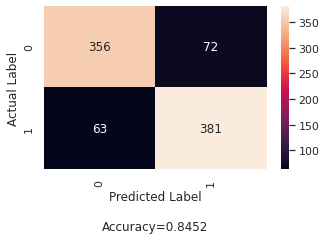

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={'figure.facecolor':'white'})

# input values
TEST_LABEL = test_label
PREDICTED_LABEL = result
labels = LABEL

accuracy = accuracy_score(TEST_LABEL, PREDICTED_LABEL)
conf_mat = confusion_matrix(TEST_LABEL, PREDICTED_LABEL)
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Label')
# plt.xlabel('Predicted Label\n\nAccuracy={:0.4f}; ROC AUC={:0.4f}'.format(accuracy, roc_score))
plt.xlabel('Predicted Label\n\nAccuracy={:0.4f}'.format(accuracy))
# plt.savefig('/content/drive/My Drive/Lafarge/Model/Hardware/HardwareModel-Confusion-v1.5.jpg')
# plt.savefig('HardwareModel-Confusion-v1.5.jpg')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# with open(saveClass, 'w') as f:
# print(classification_report(test_label, result, target_names=LABEL))
    # f.write(cap.stdout)